# **Problem 4: Applying Notch Filters to Remove Periodic Patterns**

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max

# A.

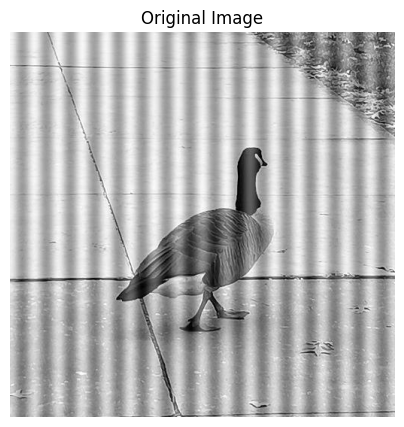

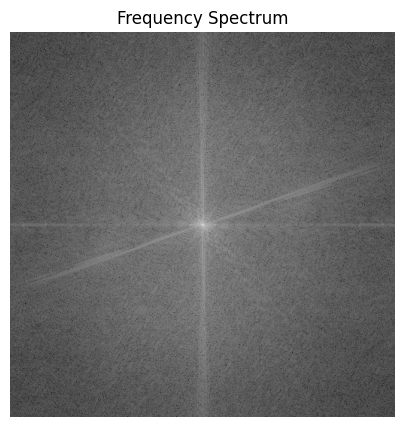

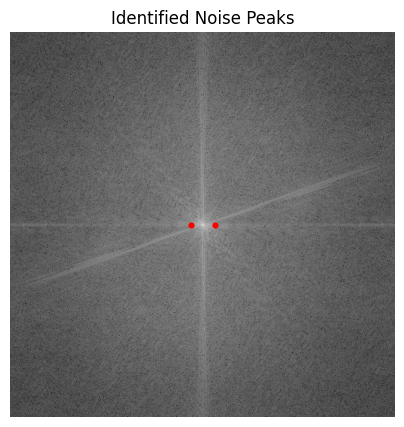

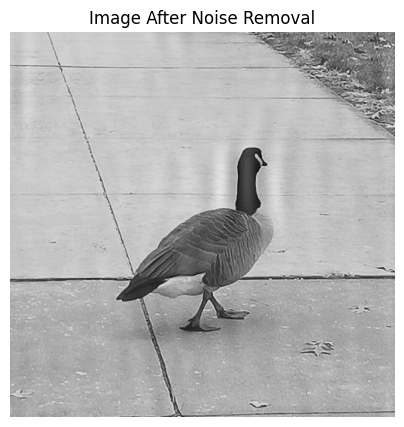

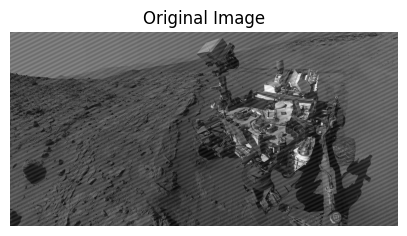

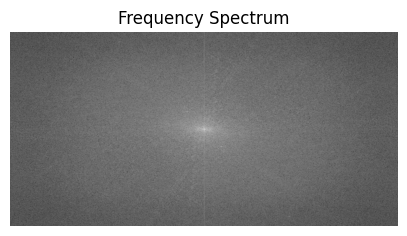

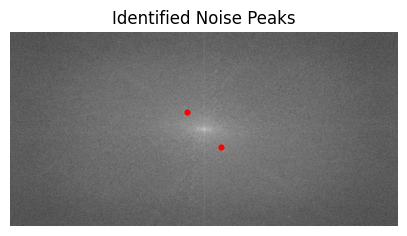

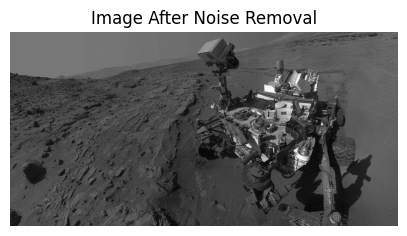

In [9]:
# load and display image
def load_and_display_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Image {image_path} not found!")
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.show()
    return image

# Function to compute and display frequency spectrum
def compute_and_display_spectrum(image):
    f = np.fft.fft2(image)   # 2D FFT of image
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)
    plt.figure(figsize=(5, 5))
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Frequency Spectrum')
    plt.axis('off')
    plt.show()
    return fshift, magnitude_spectrum

# Find noise peaks and symmetric counterparts
def find_noise_peaks(magnitude_spectrum, min_distance=10, intensity_threshold=0.8):
    # Identify local peaks
    min_peak_intensity = intensity_threshold * np.max(magnitude_spectrum)
    peaks = peak_local_max(magnitude_spectrum, min_distance=min_distance)
    
    rows, cols = magnitude_spectrum.shape
    center = (rows // 2, cols // 2)
    peaks = [peak for peak in peaks if not np.allclose(peak, center)]
    
    # Filter peaks by intensity and add symmetric counterparts 
    final_peaks = []
    for peak in peaks:
        if magnitude_spectrum[peak[0], peak[1]] > min_peak_intensity:
            final_peaks.append(peak)
            sym_peak = [rows - peak[0], cols - peak[1]]
            final_peaks.append(sym_peak)
    
    # Display identified peaks
    plt.figure(figsize=(5, 5))
    plt.imshow(magnitude_spectrum, cmap='gray')
    if final_peaks:
        peaks_array = np.array(final_peaks)
        plt.scatter(peaks_array[:, 1], peaks_array[:, 0], color='red', s=10)
    plt.title('Identified Noise Peaks')
    plt.axis('off')
    plt.show()
    return final_peaks

# Function to create notch filter mask
def create_notch_filter_mask(rows, cols, peaks, radius=5):
    mask = np.ones((rows, cols), np.float32)
    for peak in peaks:
        cx, cy = peak
        cv2.circle(mask, (cy, cx), radius, 0, -1)
    return mask

# Function to apply filter and reconstruct image
def apply_notch_filter_and_reconstruct(fshift, mask):
    fshift_filtered = fshift * mask
    f_ishift = np.fft.ifftshift(fshift_filtered)
    image_back = np.fft.ifft2(f_ishift)
    image_back = np.abs(image_back)
    image_back = np.clip(image_back, 0, 255)  # Clip values to valid range
    return image_back

# Main function to process images
def process_image(image_path, min_distance=10, intensity_threshold=0.8, radius=5):
    image = load_and_display_image(image_path)
    fshift, magnitude_spectrum = compute_and_display_spectrum(image)
    peaks = find_noise_peaks(magnitude_spectrum, min_distance, intensity_threshold)
    
    if len(peaks) == 0:
        print("No noise peaks found. Please adjust parameters.")
        return
    
    # Create notch filter mask
    mask = create_notch_filter_mask(image.shape[0], image.shape[1], peaks, radius)
    
    # Apply filter and reconstruct image
    image_filtered = apply_notch_filter_and_reconstruct(fshift, mask)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(image_filtered, cmap='gray')
    plt.title('Image After Noise Removal')
    plt.axis('off')
    plt.show()

# Execute code for images
if __name__ == "__main__":
    try:
        process_image('Goose.jpg', min_distance=10, intensity_threshold=0.8, radius=5)
        process_image('curiosity_rover_selfie.png', min_distance=10, intensity_threshold=0.8, radius=5)
    except FileNotFoundError as error:
        print(error)

# Part B.

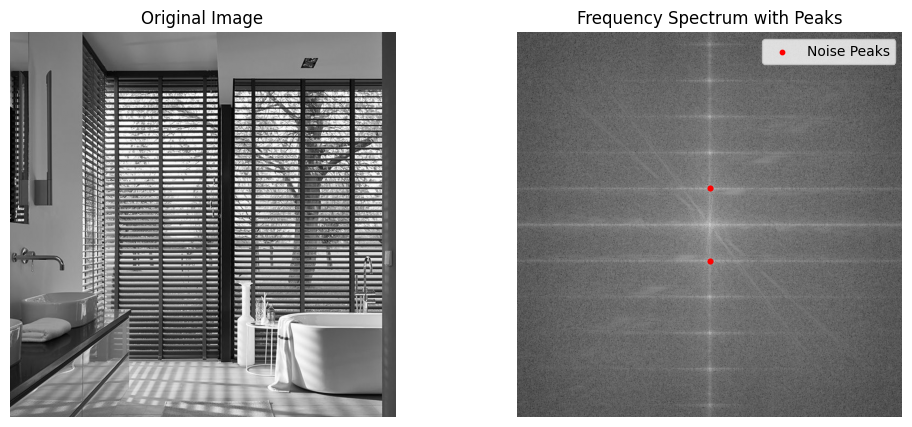

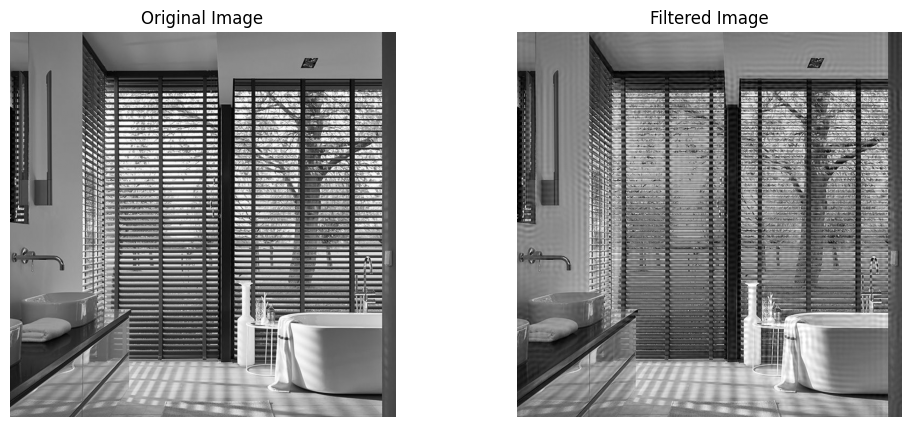

In [14]:
# load image
def load_image_gray(path):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"{path} not found")
    return image

# Compute shifted FFT and log magnitude spectrum
def compute_spectrum(image):
    F = np.fft.fft2(image)
    Fsh = np.fft.fftshift(F)
    mag = 20 * np.log(np.abs(Fsh) + 1)
    return Fsh, mag

# Detect noise peaks
def find_noise_peaks(magnitude_spectrum, min_distance=10, intensity_threshold=0.8):
    min_peak_intensity = intensity_threshold * np.max(magnitude_spectrum)
    peaks = peak_local_max(magnitude_spectrum, min_distance=min_distance)

    rows, cols = magnitude_spectrum.shape
    center = (rows // 2, cols // 2)
    peaks = [peak for peak in peaks if not np.allclose(peak, center)]
    
    # Filter peaks by intensity and add symmetric counterparts 
    final_peaks = []
    for peak in peaks:
        if magnitude_spectrum[peak[0], peak[1]] > min_peak_intensity:
            final_peaks.append(peak)
            sym_peak = [rows - peak[0], cols - peak[1]]
            final_peaks.append(sym_peak)
    
    return final_peaks

# display original image and spectrum with peaks
def show_spectrum_with_peaks(image, mag, peaks, title=""):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mag, cmap='gray')
    if peaks:
        peaks_array = np.array(peaks)
        plt.scatter(peaks_array[:, 1], peaks_array[:, 0], color='red', s=10, label='Noise Peaks')
        plt.legend()
    plt.title('Frequency Spectrum with Peaks')
    plt.axis('off')
    plt.show()

# Estimate filter parameters from peaks
def estimate_filter_params(peaks, shape):
    if not peaks:
        return 60, 20  # Default values if no peaks found
    rows, cols = shape
    cy, cx = rows // 2, cols // 2
    distances = []

    for peak in peaks:
        distance = np.sqrt((peak[0] - cy)**2 + (peak[1] - cx)**2)
        distances.append(distance)
    D0 = np.mean(distances)  # Average distance from center
    W = np.std(distances) + 10  # Bandwidth with some flexibility
    return D0, W

# Create Butterworth band-reject filter mask
def butterworth_band_reject(shape, D0, W, n):
    rows, cols = shape
    cy, cx = rows // 2, cols // 2
    Y, X = np.ogrid[:rows, :cols]
    D = np.sqrt((Y - cy)**2 + (X - cx)**2)
    H = 1 - 1 / (1 + ((D**2 - D0**2) / (W * D + 1e-6))**(2 * n))
    return np.clip(H, 0, 1)

def apply_filter(Fsh, H):
    Ff = Fsh * H
    F_ish = np.fft.ifftshift(Ff)
    image_back = np.fft.ifft2(F_ish)
    image_back = np.abs(image_back)
    image_back = np.clip(image_back, 0, 255)
    return image_back

# Show original and filtered image
def show_comparison(orig, filtered, title=""):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(orig, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(filtered, cmap='gray')
    plt.title('Filtered Image')
    plt.axis('off')
    plt.show()

# Main function to process image
def process_band_reject(path, min_distance=10, intensity_threshold=0.8, n=2):
    image = load_image_gray(path)
    Fsh, mag = compute_spectrum(image)
    
    # Identify peaks
    peaks = find_noise_peaks(mag, min_distance, intensity_threshold)
    show_spectrum_with_peaks(image, mag, peaks, title=path)
    
    if len(peaks) == 0:
        print("No noise peaks found. Please adjust parameters.")
        return
    
    D0, W = estimate_filter_params(peaks, image.shape)
    H = butterworth_band_reject(image.shape, D0, W, n)
    filtered = apply_filter(Fsh, H)
    
    # Display comparison
    show_comparison(image, filtered, title=path)


if __name__ == "__main__":
    try:
        process_band_reject('vertical_blinds_garden.jpg', min_distance=10, intensity_threshold=0.8, n=2)
    except FileNotFoundError as error:
        print(error)